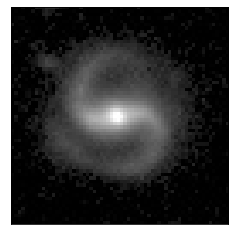

In [4]:
""" Overlay a single mask on respective image """
from PIL import Image
import matplotlib.pyplot as plt

IMG_FILE = r"..\data\Tadaki_Segmentation\set_1\orig_images\42261258421956171.jpg"
MSK_FILE = r"..\data\Tadaki_Segmentation\set_1\segmentation\42261258421956171.tif"

img = Image.open(IMG_FILE)
msk = Image.open(MSK_FILE)

plt.imshow(img, cmap='gray')
#plt.imshow(msk, cmap='gnuplot', alpha=0.2)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

1/1 [==============================] - 0s 20ms/step


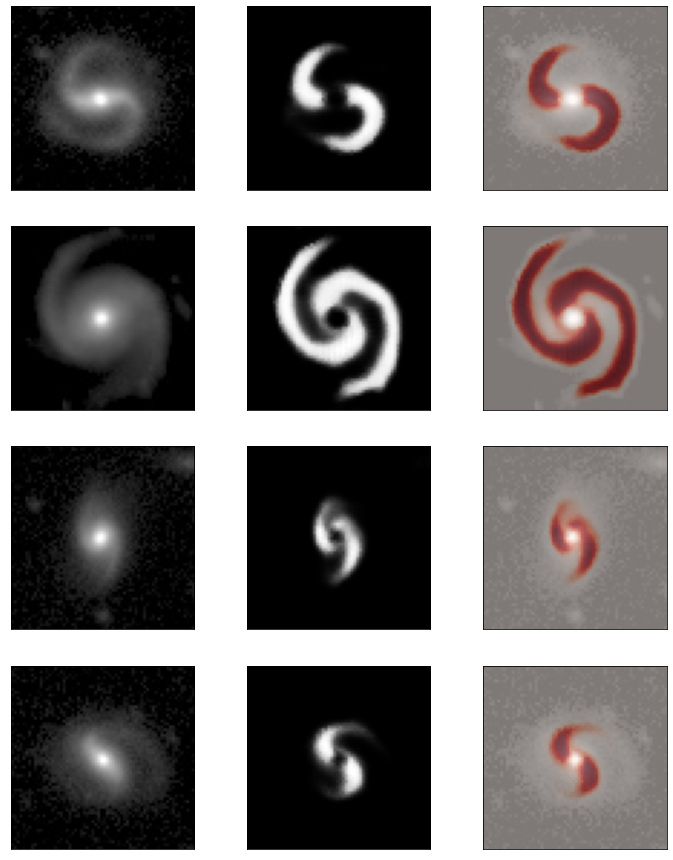

In [5]:
""" Print predictions from model """

import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

MODEL_PATH = os.path.join(os.pardir, "models", "tuned_model.keras")
image_filepaths = [
    r"..\data\Tadaki_Segmentation\set_2\images\42261258421956171.jpg",
    r"..\data\Tadaki_Segmentation\set_2\images\40576682054147100.jpg",
    r"..\data\Tadaki_Segmentation\set_2\images\40576682054152186.jpg",
    r"..\data\Tadaki_Segmentation\set_2\images\42204354400250369.jpg",
    ]

model = tf.keras.models.load_model(MODEL_PATH)

imgs = [np.expand_dims(np.array(Image.open(fp)), axis=0) for fp in image_filepaths]

preds = [model.predict(tf.convert_to_tensor(img, dtype=tf.float64)) for img in imgs]

plt.figure(figsize=(12,60))

for n, img in enumerate(imgs):
    img = img.reshape((64,64))
    pred = preds[n].reshape((64,64))

    plt.subplot(15,3,3*n+1)
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(15,3,3*n+2)
    plt.imshow(pred, cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(15,3,3*n+3)
    plt.imshow(img, cmap='gray')
    plt.imshow(pred, cmap='Reds', alpha=0.5)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    

plt.show()


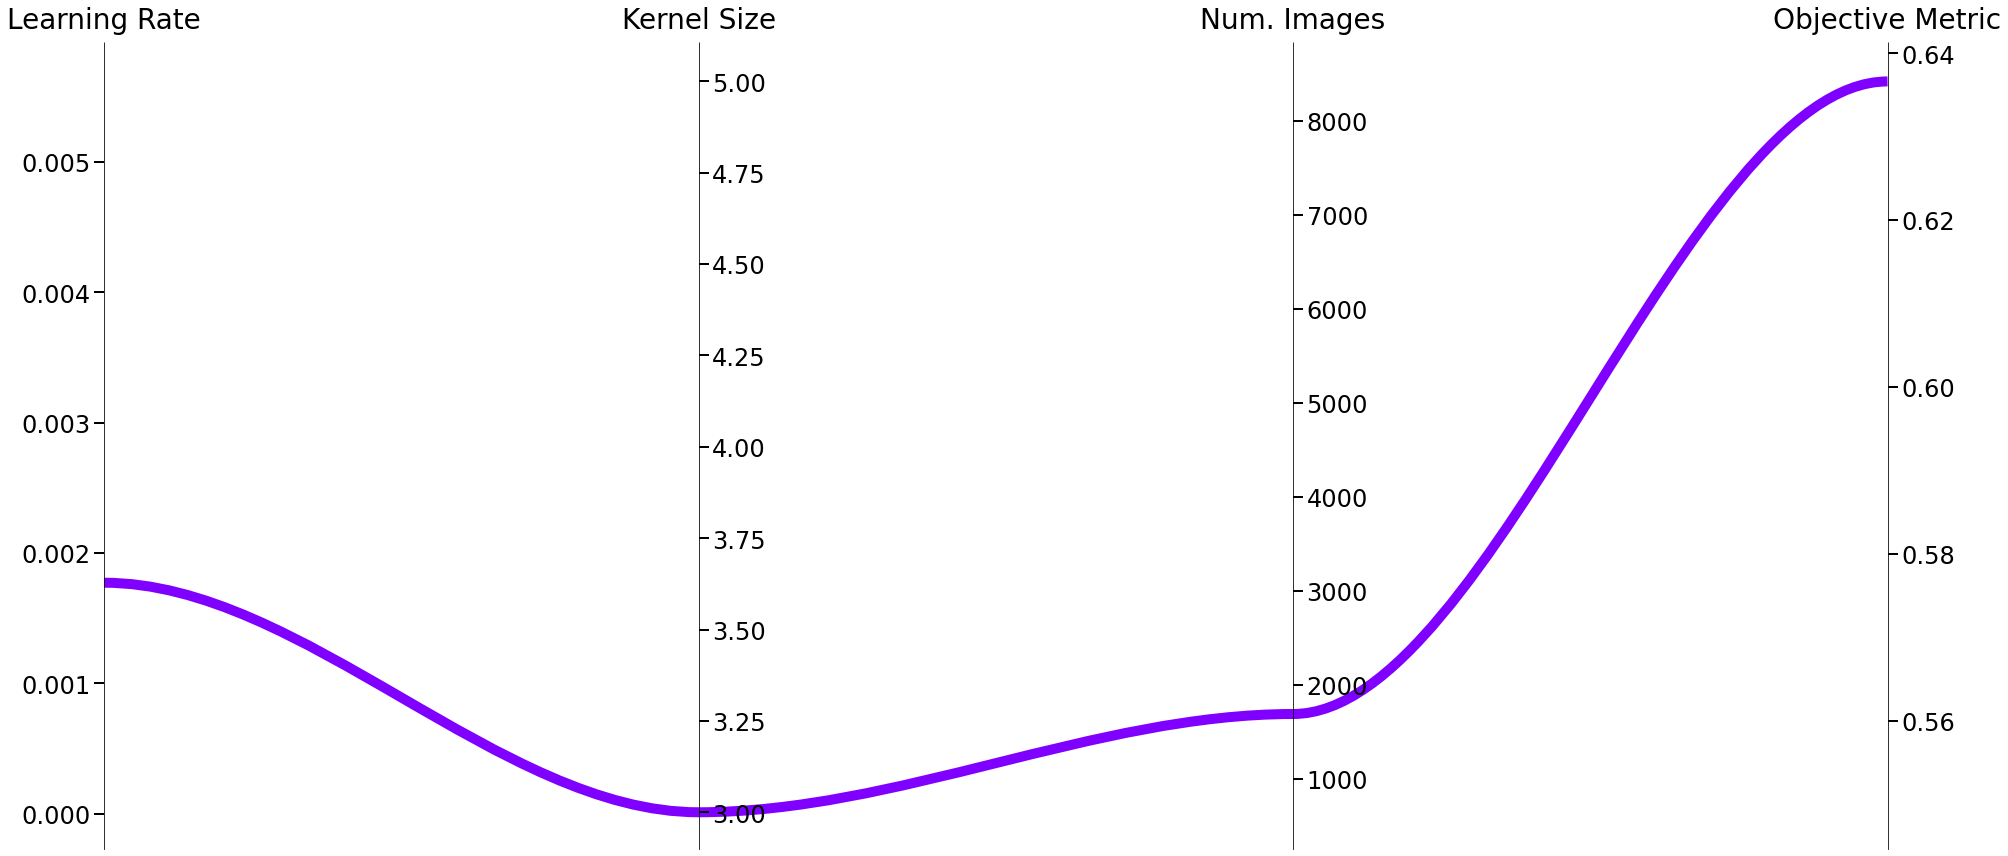

[1.77197778e-03 3.00000000e+00 1.69300000e+03 6.36623167e-01]


In [87]:
# Credit: Inspired by https://stackoverflow.com/a/60401570/10341389
""" Plot Parallel Coordinates plot of Hyperparameter Combinations """
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import json


"""
Expects following JSON shape
    {
        "Objective": OBJECTIVE_TITLE
        "Results": [
            {
                "Trial": TRIAL_ID,
                "Hyperparameters": {
                    "learning_rate": float,
                    "kernel_size": int,
                    "num_images": int,
                    "Score": float
                }
            }
        ]
    }
"""
HP_RESULTS_FILE = r"..\models\hp_tuning_results.json"

with open(HP_RESULTS_FILE, "r") as read_file:
    data = json.load(read_file)

fig, host = plt.subplots(figsize=(28,12))

# create some dummy data
ynames = ['Learning Rate', 'Kernel Size', 'Num. Images', "Objective Metric"]
y1 = [d['Hyperparameters']['learning_rate'] for d in data['Results']]
y2 = [d['Hyperparameters']['kernel_size'] for d in data['Results']]
y3 = [d['Hyperparameters']['num_images'] for d in data['Results']]
y4 = [-d['Hyperparameters']['Score'] for d in data['Results']]

# organize the data
ys = np.dstack([y1, y2, y3, y4])[0]
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='y', labelsize=24, length=10, width=2)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=28)
host.tick_params(axis='x', which='major', pad=7)

host.spines['right'].set_visible(False)
host.xaxis.tick_top()
#host.set_title('Hyperparameter Tuning: Parallel Coordinates Plot', fontsize=18,y=1.1)

cmap = plt.cm.get_cmap('rainbow_r')
norm = mpl.colors.Normalize(vmin=min(y4), vmax=max(y4))

for j in range(1):
    
    # to just draw straight lines between the axes:
    # host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])

    # create bezier curves
    # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
    #   at one third towards the next axis; the first and last axis have one less control vertex
    # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
    # y-coordinate: repeat every point three times, except the first and last only twice
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=10, edgecolor=cmap(norm(y4[j])))
    host.add_patch(patch)
plt.tight_layout()
plt.show()
print(ys[0])

1/1 [==============================] - 0s 18ms/step


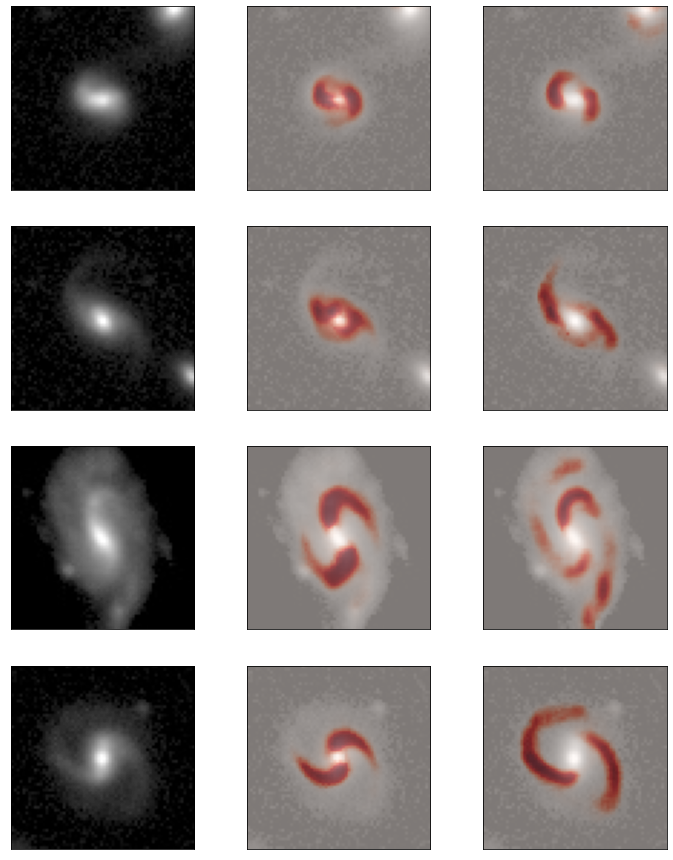

In [91]:
""" Print predictions from model """

import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

MODEL2_PATH = os.path.join(os.pardir, "models", "tuned_model.keras")
MODEL3_PATH = os.path.join(os.pardir, "models", "tuned_model_set_3.keras")

image_filepaths = [
    r"..\data\Tadaki+20_spiral\Tadaki+20_S\42098818463852302.jpg",
    r"..\data\Tadaki+20_spiral\Tadaki+20_S\42204637868088818.jpg",
    r"..\data\Tadaki+20_spiral\Tadaki+20_S\42265776727554656.jpg",
    r"..\data\Tadaki+20_spiral\Tadaki+20_S\42265944231278194.jpg",
    ]

model_set2 = tf.keras.models.load_model(MODEL2_PATH)
model_set3 = tf.keras.models.load_model(MODEL3_PATH)

imgs = [np.expand_dims(np.array(Image.open(fp)), axis=0) for fp in image_filepaths]

preds_set2 = [model_set2.predict(tf.convert_to_tensor(img, dtype=tf.float64)) for img in imgs]
preds_set3 = [model_set3.predict(tf.convert_to_tensor(img, dtype=tf.float64)) for img in imgs]

plt.figure(figsize=(12,60))

for n, img in enumerate(imgs):
    img = img.reshape((64,64))
    pred_2 = preds_set2[n].reshape((64,64))
    pred_3 = preds_set3[n].reshape((64,64))
    
    plt.subplot(15,3,3*n+1)
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(15,3,3*n+2)
    plt.imshow(img, cmap='gray')
    plt.imshow(pred_2, cmap='Reds', alpha=0.5)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(15,3,3*n+3)
    plt.imshow(img, cmap='gray')
    plt.imshow(pred_3, cmap='Reds', alpha=0.5)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    

plt.show()
